# Entregable Spark

## Caso de Uso

El objetivo principal de este caso de uso es realizar un análisis comparativo de la percepción de la felicidad en diferentes países a lo largo del tiempo utilizando datos del World Happiness Report. En particular, se busca identificar y comprender las variaciones en la puntuación de felicidad entre dos informes anuales consecutivos. Esto permite detectar tendencias, cambios significativos y posibles factores que influyen en la felicidad de las poblaciones a nivel mundial.



**Objetivos Específicos**
1. Evaluar cómo ha evolucionado la puntuación de felicidad de los países entre dos informes anuales consecutivos del World Happiness Report.

2. Identificar los países que han experimentado las mayores mejoras y los mayores declives en su percepción de felicidad

3. Proporcionar información visual y clara sobre las tendencias de felicidad a lo largo del tiempo, utilizando gráficos y tablas descriptivas

4. Extraer conclusiones sobre los cambios en la percepción de la felicidad y su posible impacto en la calidad de vida de las poblaciones estudiadas

### Prerequisitos, Instalamos Spark y Java

In [1]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark 3.5.0
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0//spark-3.5.0-bin-hadoop3.tgz

In [2]:
ls -l # check the .tgz is there


total 782032
drwxr-xr-x  1 root root      4096 Feb 27 14:34 sample_data/
drwxr-xr-x 13 1000 1000      4096 Sep  9 02:08 spark-3.5.0-bin-hadoop3/
-rw-r--r--  1 root root 400395283 Sep  9 02:10 spark-3.5.0-bin-hadoop3.tgz
-rw-r--r--  1 root root 400395283 Sep  9 02:10 spark-3.5.0-bin-hadoop3.tgz.1


In [3]:
# unzip it
!tar xf spark-3.5.0-bin-hadoop3.tgz

In [4]:
!pip install -q findspark


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master local[*] pyspark-shell"

### Iniciamos la sesión de Spark y leemos y declaramos los Dataframes

In [6]:
import findspark
findspark.init("spark-3.5.0-bin-hadoop3")# SPARK_HOME

from pyspark.sql import SparkSession

# create the session
spark = SparkSession \
        .builder \
        .appName("Joins") \
        .master("local[*]") \
        .config("spark.ui.port", "4500") \
        .getOrCreate()

spark.version

'3.5.0'

In [7]:
spark

In [8]:
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, round, row_number
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.sql.types import FloatType



In [9]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [10]:
csv_file_path_2019 = '/gdrive/MyDrive/MDATA/2019.csv'
csv_file_path_2018 = '/gdrive/MyDrive/MDATA/2018.csv'

df_2019 = spark.read.csv(csv_file_path_2019, header=True, inferSchema=True)
df_2018 = spark.read.csv(csv_file_path_2018, header=True, inferSchema=True)

df_2019.show(3)

+------------+-----------------+-----+--------------+--------------+-----------------------+----------------------------+----------+-------------------------+
|Overall rank|Country or region|Score|GDP per capita|Social support|Healthy life expectancy|Freedom to make life choices|Generosity|Perceptions of corruption|
+------------+-----------------+-----+--------------+--------------+-----------------------+----------------------------+----------+-------------------------+
|           1|          Finland|7.769|          1.34|         1.587|                  0.986|                       0.596|     0.153|                    0.393|
|           2|          Denmark|  7.6|         1.383|         1.573|                  0.996|                       0.592|     0.252|                     0.41|
|           3|           Norway|7.554|         1.488|         1.582|                  1.028|                       0.603|     0.271|                    0.341|
+------------+-----------------+-----+--------

In [11]:
csv_file_path_freedom = '/gdrive/MyDrive/MDATA/economic_freedom.csv'

df_freedom = spark.read.csv(csv_file_path_freedom, header=True, inferSchema=True)
df_freedom.show(4)

+---------+------------+-----------+--------------------+----------+-----------+----------+---------------+---------------------+--------------------+----------+--------------+-------------+----------------+-------------+----------------+-------------+-------------------+-----------------+---------------+-------------------+----------------------+-------------------+---------------------------+-----------+---------------------+-------------------+-------------------+--------------------------+--------------------+----------------+-------------+---------------------+----------------------+
|CountryID|Country Name|    WEBNAME|              Region|World Rank|Region Rank|2019 Score|Property Rights|Judical Effectiveness|Government Integrity|Tax Burden|Gov't Spending|Fiscal Health|Business Freedom|Labor Freedom|Monetary Freedom|Trade Freedom|Investment Freedom |Financial Freedom|Tariff Rate (%)|Income Tax Rate (%)|Corporate Tax Rate (%)|Tax Burden % of GDP|Gov't Expenditure % of GDP |    Cou

## Pruebas y conclusiones

### Primeros resultados
En la siguiente tabla creada podremos ver una comparativa de los dos años y ver la evolución de los países.

Además de un ranking con los países con mejor performance durante el periodo estudiado.

In [12]:
df_2019_selected = df_2019.select("Country or region", "Score").withColumnRenamed("Country or region", "Country").withColumnRenamed("Score", "Score_2019")
df_2018_selected = df_2018.select("Country or region", "Score").withColumnRenamed("Country or region", "Country").withColumnRenamed("Score", "Score_2018")

df_objetivo_1 = df_2019_selected.join(df_2018_selected, "Country")

df_objetivo_1 = df_objetivo_1.withColumn("Variation", col("Score_2019") - col("Score_2018"))
df_objetivo_1 = df_objetivo_1.withColumn("Average Score", (col("Score_2018") + col("Score_2019")) / lit(2))
df_objetivo_1 = df_objetivo_1.orderBy("Average Score", ascending=False)

window_spec = Window.orderBy(col("Average Score").desc())
df_objetivo_1 = df_objetivo_1.withColumn("Ranking", rank().over(window_spec))

for column in ["Average Score", "Variation", "Score_2019", "Score_2018"]:
    df_objetivo_1 = df_objetivo_1.withColumn(column, round(col(column), 4))

df_objetivo_1 = df_objetivo_1.select("Ranking", "Country", "Average Score", "Variation", "Score_2019", "Score_2018") \
    .orderBy("Ranking")

df_objetivo_1.show()

+-------+--------------------+-------------+---------+----------+----------+
|Ranking|             Country|Average Score|Variation|Score_2019|Score_2018|
+-------+--------------------+-------------+---------+----------+----------+
|      1|             Finland|       7.7005|    0.137|     7.769|     7.632|
|      2|             Denmark|       7.5775|    0.045|       7.6|     7.555|
|      3|              Norway|        7.574|    -0.04|     7.554|     7.594|
|      4|             Iceland|       7.4945|   -0.001|     7.494|     7.495|
|      5|         Switzerland|       7.4835|   -0.007|      7.48|     7.487|
|      6|         Netherlands|       7.4645|    0.047|     7.488|     7.441|
|      7|              Sweden|       7.3285|    0.029|     7.343|     7.314|
|      8|         New Zealand|       7.3155|   -0.017|     7.307|     7.324|
|      9|              Canada|        7.303|    -0.05|     7.278|     7.328|
|     10|           Australia|         7.25|   -0.044|     7.228|     7.272|

### Aquí podremos observar los mejores países durante estos años y los peores en cuanto a evolución de su Score de Felicidad

In [13]:
df_objetivo_1 = df_objetivo_1.orderBy("Variation")
df_objetivo_1.show()

+-------+--------------+-------------+---------+----------+----------+
|Ranking|       Country|Average Score|Variation|Score_2019|Score_2018|
+-------+--------------+-------------+---------+----------+----------+
|     58|      Malaysia|       5.8305|   -0.983|     5.339|     6.322|
|    146|   Afghanistan|       3.4175|   -0.429|     3.203|     3.632|
|    152|   South Sudan|       3.0535|   -0.401|     2.853|     3.254|
|     74|  Turkmenistan|       5.4415|   -0.389|     5.247|     5.636|
|    100|       Somalia|        4.825|   -0.314|     4.668|     4.982|
|     35|     Argentina|        6.237|   -0.302|     6.086|     6.388|
|    133|        Zambia|        4.242|    -0.27|     4.107|     4.377|
|     95|        Jordan|       5.0335|   -0.255|     4.906|     5.161|
|    131|         Egypt|       4.2925|   -0.253|     4.166|     4.419|
|    117|  Sierra Leone|       4.4725|   -0.197|     4.374|     4.571|
|    144|        Malawi|       3.4985|   -0.177|      3.41|     3.587|
|    1

In [14]:
df_objetivo_1 = df_objetivo_1.orderBy("Variation", ascending=False)
df_objetivo_1.show()

+-------+--------------------+-------------+---------+----------+----------+
|Ranking|             Country|Average Score|Variation|Score_2019|Score_2018|
+-------+--------------------+-------------+---------+----------+----------+
|    149|             Burundi|         3.34|     0.87|     3.775|     2.905|
|    114|               Benin|        4.512|    0.742|     4.883|     4.141|
|    132|              Guinea|        4.249|     0.57|     4.534|     3.964|
|    140|             Liberia|        3.735|     0.48|     3.975|     3.495|
|    126|               Niger|        4.397|    0.462|     4.628|     4.166|
|     57|              Kosovo|        5.881|    0.438|       6.1|     5.662|
|     66|            Honduras|        5.682|    0.356|      5.86|     5.504|
|     99|               Ghana|       4.8265|    0.339|     4.996|     4.657|
|     16|              Israel|       6.9765|    0.325|     7.139|     6.814|
|     52|              Cyprus|        5.904|    0.284|     6.046|     5.762|

### Gráfico de Variaciones

Aquí podremos observar un histograma que representa la variación en las puntuaciones de felicidad de los países entre los años 2018 y 2019, presumiblemente basado en datos del World Happiness Report

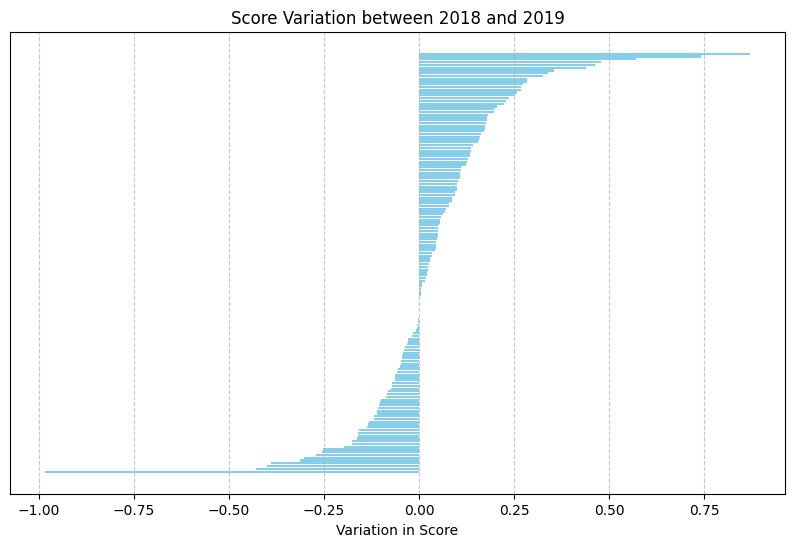

In [15]:
variations = df_objetivo_1.select("Variation").collect()

score_variations = [row["Variation"] for row in variations]

plt.figure(figsize=(10, 6))
plt.barh(range(len(score_variations)), score_variations, color='skyblue')
plt.xlabel('Variation in Score')
plt.title('Score Variation between 2018 and 2019')
plt.gca().invert_yaxis()
plt.yticks([])
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

**Una interpretación más detallada del gráfico podria ser que:**

1. Mayoría de Incrementos: La concentración de barras hacia el lado derecho del histograma indica que la mayoría de los países experimentaron un aumento en su índice de felicidad de un año al otro.

2. Mejoras Significativas: Existen varias barras extensas hacia la derecha, lo que sugiere que algunos países tuvieron mejoras notables en su puntuación de felicidad.

3. Menoría de Disminuciones: Hay un número relativamente pequeño de barras que se extienden hacia la izquierda del eje cero, mostrando que pocos países vieron una disminución en su puntuación de felicidad.

4. Tendencia General Positiva: La distribución de las barras refleja una tendencia general positiva en la variación de las puntuaciones, lo cual es un indicativo de que, en términos globales, la percepción de felicidad podría estar mejorando

## Ahora comenzaremos a analizar correlaciones de las columnas, para ver como afectan diferentes indices al Score de Felicidad de los países.

Estudiaremos tanto los del propio dataset como uno externo de libertad.

In [16]:
correlation_scores = {
    column: df_2019.select(corr(column, "Score")).collect()[0][0]
    for column in df_2019.columns
    if column != "Score" and column != "Country or region" and column != "Overall rank"
}

print("Correlaciones con el puntaje de felicidad:")
for column, correlation in correlation_scores.items():
    print(f"{column}: {correlation}")


Correlaciones con el puntaje de felicidad:
GDP per capita: 0.7938828678781278
Social support: 0.7770577880638648
Healthy life expectancy: 0.7798831492425832
Freedom to make life choices: 0.5667418257199904
Generosity: 0.07582369490389741
Perceptions of corruption: 0.3856130708664786


### Estos resultados muestran cómo diversas variables se relacionan con el puntaje de felicidad:

1. GDP per capita, Social support y Healthy life expectancy: Tienen correlaciones positivas fuertes, indicando que mejores condiciones económicas, apoyo social y salud están asociadas con mayor felicidad.

3. Freedom to make life choices: Tiene una correlación moderada y positiva, resaltando la importancia de la autonomía en la percepción de felicidad.

4. Generosity: Tiene una correlación muy baja, lo que sugiere que la generosidad del país tiene poco impacto en la felicidad percibida.

5. Perceptions of corruption: Tiene una correlación moderada y negativa, indicando que mayor corrupción está asociada con menor felicidad percibida.

In [17]:
columns_to_convert = [
    "World Rank", "2019 Score", "Business Freedom", "Labor Freedom", "Monetary Freedom",
    "Trade Freedom", "Financial Freedom"
]

for column in columns_to_convert:
    df_freedom = df_freedom.withColumn(column, col(column).cast(FloatType()))

df_2019 = df_2019.withColumn("Country or region", trim(col("Country or region")))
df_freedom = df_freedom.withColumn("Country Name", trim(col("Country Name")))

df_joined = df_2019.join(df_freedom, df_2019["Country or region"] == df_freedom["Country Name"])

columns_to_correlate = [
    "World Rank", "2019 Score", "Business Freedom", "Labor Freedom",
]

for column in columns_to_correlate:
    correlation = df_joined.stat.corr("Score", column)
    print(f"Correlación entre el Score Hapyness y {column}: {correlation}")


Correlación entre el Score Hapyness y World Rank: -0.5748985165217124
Correlación entre el Score Hapyness y 2019 Score: 0.5674392431474475
Correlación entre el Score Hapyness y Business Freedom: 0.6675093279446097
Correlación entre el Score Hapyness y Labor Freedom: 0.24877581068827342


Los resultados de las correlaciones entre el Score de Felicidad y diversas variables económicas y de libertad proporcionan insights valiosos sobre cómo diferentes aspectos de la gobernanza y la economía pueden influir en la felicidad de los países:

1. World Rank (-0.57): Los países con mejores posiciones en el ranking mundial tienden a tener mayores niveles de felicidad, reflejando la importancia de una gestión gubernamental sólida y un entorno socioeconómico estable.

2. 2019 Score (0.57): El progreso económico y social se relaciona positivamente con la felicidad, indicando que un mayor desarrollo está asociado con una mayor percepción de bienestar.

3. Business Freedom (0.67): La libertad empresarial está fuertemente vinculada a la felicidad, sugiriendo que menos restricciones gubernamentales y más apertura al mercado se traducen en mayor satisfacción general.

4. Labor Freedom (0.25): Aunque la libertad laboral influye en la felicidad, su impacto es relativamente menor en comparación con otras variables como la libertad empresarial y el desarrollo económico.